# Cell 1: Load cleaned transactions

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/processed/fact_transactions.csv', parse_dates=['DATE'])
print(f"Loaded {len(df):,} transactions")

Loaded 2,570,651 transactions


# Cell 2: Calculate inter-purchase intervals

In [11]:
# Create a basket-level dataframe (drop duplicate days for the same household)
baskets = df[['household_key', 'DATE']].drop_duplicates().sort_values(['household_key', 'DATE'])

# Calculate days between VISITS (not items)
baskets['prev_date'] = baskets.groupby('household_key')['DATE'].shift(1)
baskets['days_between'] = (baskets['DATE'] - baskets['prev_date']).dt.days

# Drop NaNs (first visit) and filter out 0s if any remain (though drop_duplicates should handle it)
intervals = baskets['days_between'].dropna()
intervals = intervals[intervals > 0]  # Optional safety check

print(f"Calculated {len(intervals):,} inter-visit intervals")

Calculated 210,902 inter-visit intervals


# Cell 3: Statistical Summary

In [12]:
print("=== INTER-VISIT INTERVAL STATISTICS ===")
print(f"Mean:   {intervals.mean():.1f} days")
print(f"Median: {intervals.median():.1f} days")
print(f"Std:    {intervals.std():.1f} days")
print(f"Min:    {intervals.min():.0f} days")
print(f"Max:    {intervals.max():.0f} days")
print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {intervals.quantile(p/100):.1f} days")

=== INTER-VISIT INTERVAL STATISTICS ===
Mean:   7.3 days
Median: 4.0 days
Std:    16.5 days
Min:    1 days
Max:    666 days

Percentiles:
  25th: 2.0 days
  50th: 4.0 days
  75th: 7.0 days
  90th: 15.0 days
  95th: 24.0 days
  99th: 64.0 days


# Cell 4: Histogram

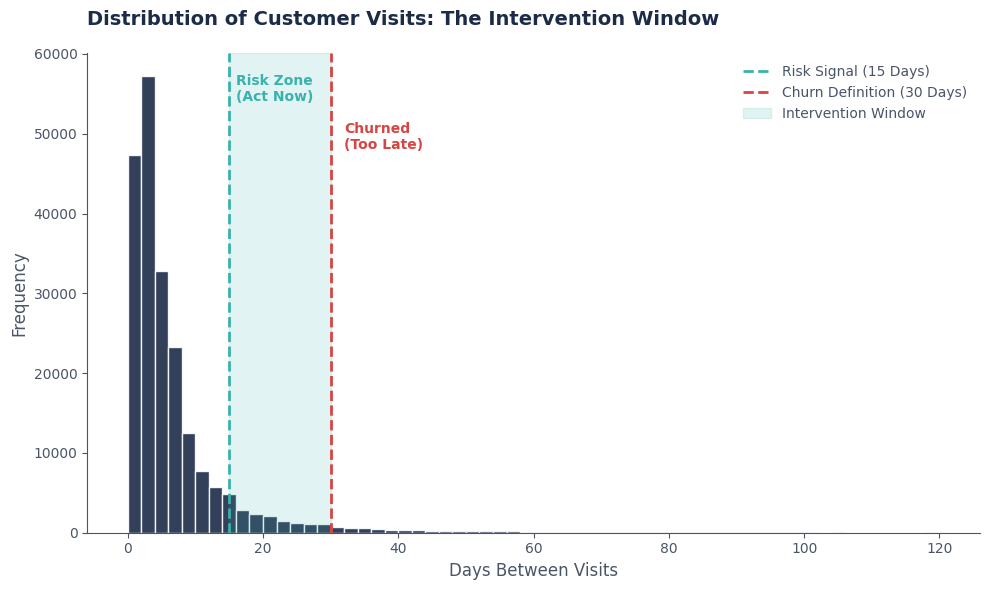

In [13]:
import matplotlib.pyplot as plt

# --- Design System Constants ---
COLOR_PRIMARY = '#1B2B48'   # Lucky Point (Deep Navy)
COLOR_HIGHLIGHT = '#39B2AB' # Keppel (Teal)
COLOR_WARNING = '#D64541'   # Terracotta (Red)
COLOR_TEXT = '#4A5568'      # Slate
BG_COLOR = '#FFFFFF'        # White Container

fig, ax = plt.subplots(figsize=(10, 6), facecolor=BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 1. Histogram (Limit to 120 days for focus)
n, bins, patches = ax.hist(
    intervals[intervals <= 120], 
    bins=60, 
    range=(0, 120), 
    edgecolor='white', 
    color=COLOR_PRIMARY, 
    alpha=0.9
)

# 2. Add Threshold Lines
# A. Statistical Signal (start of risk) - ~15 Days
ax.axvline(x=15, color=COLOR_HIGHLIGHT, linestyle='--', linewidth=2, label='Risk Signal (15 Days)')

# B. Business Threshold (start of churn) - 30 Days
ax.axvline(x=30, color=COLOR_WARNING, linestyle='--', linewidth=2, label='Churn Definition (30 Days)')

# 3. Highlight the "Intervention Window"
# This shades the area between 15 and 30 days
ax.axvspan(15, 30, color=COLOR_HIGHLIGHT, alpha=0.15, label='Intervention Window')

# 4. Annotations & Grouping
ax.text(x=16, y=ax.get_ylim()[1]*0.9, s='Risk Zone\n(Act Now)', 
        color=COLOR_HIGHLIGHT, fontsize=10, fontweight='bold')

ax.text(x=32, y=ax.get_ylim()[1]*0.8, s='Churned\n(Too Late)', 
        color=COLOR_WARNING, fontsize=10, fontweight='bold')

# 5. Minimalist Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_TEXT)
ax.spines['bottom'].set_color(COLOR_TEXT)
ax.tick_params(axis='x', colors=COLOR_TEXT)
ax.tick_params(axis='y', colors=COLOR_TEXT)

# 6. Labels
ax.set_title('Distribution of Customer Visits: The Intervention Window', 
             fontsize=14, fontweight='bold', color=COLOR_PRIMARY, pad=20, loc='left')
ax.set_xlabel('Days Between Visits', fontsize=12, color=COLOR_TEXT)
ax.set_ylabel('Frequency', fontsize=12, color=COLOR_TEXT)

# Move legend to not block data
ax.legend(frameon=False, loc='upper right', labelcolor=COLOR_TEXT)

plt.tight_layout()
plt.savefig('../docs/assets/inter_visit_distribution.png', dpi=150)
plt.show()

# Cell 5: Threshold Evaluation

In [15]:
# Cell 5: Threshold Selection & Sensitivity Analysis
# ALIGNMENT: Matches logic defined in METHODOLOGY.md

# 1. Calculate the Statistical "Upper Fence" (the baseline)
# Logic: Q3 + 1.5 * IQR. Any gap longer than this is a "statistical anomaly"
Q1 = intervals.quantile(0.25)
Q3 = intervals.quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + (1.5 * IQR)

print(f"=== STATISTICAL BASELINE ===")
print(f"Upper Fence: {upper_fence:.1f} days")
print(f"Interpretation: Gaps > {upper_fence:.1f} days are statistical outliers.")

# 2. Perform Sensitivity Analysis (The business logic)
# We test 3 candidates: 15 days (Fence), 30 days (Buffer), 90 days (Quarterly)

# We need 'Recency' to count how many people would be flagged
max_date = df['DATE'].max()
user_recency = (max_date - df.groupby('household_key')['DATE'].max()).dt.days

candidates = [15, 30, 90]

print(f"\n=== SENSITIVITY ANALYSIS (Who gets flagged?) ===")
print(f"{'Threshold':<15} | {'Risk Window':<15} | {'At-Risk Count':<15} | {'Business Implication'}")
print("-" * 85)

for t in candidates:
    # Define Risk Window per Methodology:
    # 15d Threshold -> Risk is 7-15 days
    # 30d Threshold -> Risk is 15-30 days
    # 90d Threshold -> Risk is 60-90 days
    if t == 15:
        w_start, w_end = 7, 15
        note = "Too sensitive (spam risk)"
    elif t == 30:
        w_start, w_end = 15, 30
        note = "Actionable cohort"
    else:
        w_start, w_end = 60, 90
        note = "Too lagging, customer is churned"
        
    # Count customers currently in this window
    risk_count = user_recency[(user_recency >= w_start) & (user_recency <= w_end)].count()
    
    print(f"{t} Days{'':<8} | {w_start}-{w_end} Days{'':<5} | {risk_count:<15} | {note}")

# 3. Final Decision
CHURN_THRESHOLD = 30
print(f"DECISION SELECTED: {CHURN_THRESHOLD} Days")

=== STATISTICAL BASELINE ===
Upper Fence: 14.5 days
Interpretation: Gaps > 14.5 days are statistical outliers.

=== SENSITIVITY ANALYSIS (Who gets flagged?) ===
Threshold       | Risk Window     | At-Risk Count   | Business Implication
-------------------------------------------------------------------------------------
15 Days         | 7-15 Days      | 430             | Too sensitive (spam risk)
30 Days         | 15-30 Days      | 346             | Actionable cohort
90 Days         | 60-90 Days      | 95              | Too lagging, customer is churned
DECISION SELECTED: 30 Days


# Cell 6: Statistical Justification

In [16]:
median = intervals.median()
q1 = intervals.quantile(0.25)
q3 = intervals.quantile(0.75)
iqr = q3 - q1

upper_fence = q3 + 1.5 * iqr

print(f"Upper Fence (Statistical Break in Habit): {upper_fence:.1f} days")
print(f"Selected Threshold (Business Definition): 30 days")
print(f"Multiples of Median: 30 days is {30/median:.1f}x the typical shopping cycle.")
print("Conclusion: 30 days is an actionable threshold effectively isolating true churners from vacationers.")

Upper Fence (Statistical Break in Habit): 14.5 days
Selected Threshold (Business Definition): 30 days
Multiples of Median: 30 days is 7.5x the typical shopping cycle.
Conclusion: 30 days is an actionable threshold effectively isolating true churners from vacationers.


# Cell 7: Strategic RFM Segmentation (Implementation)
## This implements the logic defined in METHODOLOGY.md Section 2

In [18]:
# 1. Calculate Recency (Days since last visit) for every household
max_date = df['DATE'].max()

rfm = df.groupby('household_key').agg({
    # FIX: Remove '.dt' - operate directly on the scalar result
    'DATE': lambda x: (max_date - x.max()).days, 
    'BASKET_ID': 'nunique',
    'SALES_VALUE': 'sum'
}).rename(columns={
    'DATE': 'Recency',
    'BASKET_ID': 'Frequency',
    'SALES_VALUE': 'Monetary'
})

# 2. Assign Strategic Recency Score (R)
# Logic: Hard-coded bins based on Churn Analysis (Median=4, Threshold=30)
def get_r_score(days):
    if days <= 7: return 5   # Active (Habitual)
    if days <= 14: return 4  # Active (Slipping)
    if days <= 30: return 3  # Risk Zone (Intervention)
    if days <= 60: return 2  # Churned (Recent)
    return 1                 # Lost

rfm['R_Score'] = rfm['Recency'].apply(get_r_score)

# 3. Calculate F & M Scores (Relative)
# CRITICAL: Only calculate percentiles for Active/At-Risk users (R >= 3)
# This prevents "dead" customers from skewing the curve for active ones.
active_mask = rfm['R_Score'] >= 3
active_data = rfm[active_mask]

# Create quartiles (1-4) for F and M on active data only
# Use 'duplicates="drop"' to handle edges cases where multiple quartiles are 0 or 1
rfm.loc[active_mask, 'F_Score'] = pd.qcut(active_data['Frequency'], 4, labels=[1, 2, 3, 4], duplicates='drop').astype(int)
rfm.loc[active_mask, 'M_Score'] = pd.qcut(active_data['Monetary'], 4, labels=[1, 2, 3, 4], duplicates='drop').astype(int)

# Fill inactive users with 1
rfm[['F_Score', 'M_Score']] = rfm[['F_Score', 'M_Score']].fillna(1).astype(int)

# 4. Define Segments
def get_segment(row):
    r, f = row['R_Score'], row['F_Score']
    if r == 5 and f == 4: return "Champion"
    if r >= 4 and f >= 3: return "Loyalist"
    if r >= 4 and f <= 2: return "Potential Loyal"
    if r == 3: return "At Risk (Intervention)"
    if r == 2: return "Hibernating"
    return "Lost"

rfm['Segment'] = rfm.apply(get_segment, axis=1)

# 5. Validate Alignment
print("=== SEGMENT VALIDATION (Does it match Methodology?) ===")
validation = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'count' # Using Frequency column just to count rows
}).rename(columns={'Frequency': 'Count', 'Recency': 'Avg_Days_Inactive'}).sort_values('Avg_Days_Inactive')

display(validation.style.format({'Avg_Days_Inactive': '{:.1f}'}))

=== SEGMENT VALIDATION (Does it match Methodology?) ===


,Avg_Days_Inactive,Count
Segment,,
Champion,1.9,449
Loyalist,4.2,487
Potential Loyal,5.1,755
At Risk (Intervention),20.7,346
Hibernating,43.8,199
Lost,164.2,264
